In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import dirname as dirname
import os
import numpy as np
from scipy import stats
import datetime
from math import sqrt

In [3]:
test_name="final_base_agent_{}"
group_size = 4
n_logs = 1
log_start_index = 0
n_groups = 100
all_data = []
for j in range(n_groups):
    subset = []
    for i in range(n_logs):
        data = pd.read_csv("{}_log_{}_group_{}.csv".format(test_name,str(i+log_start_index),str(j)),parse_dates=['Date',]).set_index('Date',drop=False)
        subset.append(data)
    all_data.append(subset)
data = all_data[0][0]

<Figure size 1152x5040 with 0 Axes>

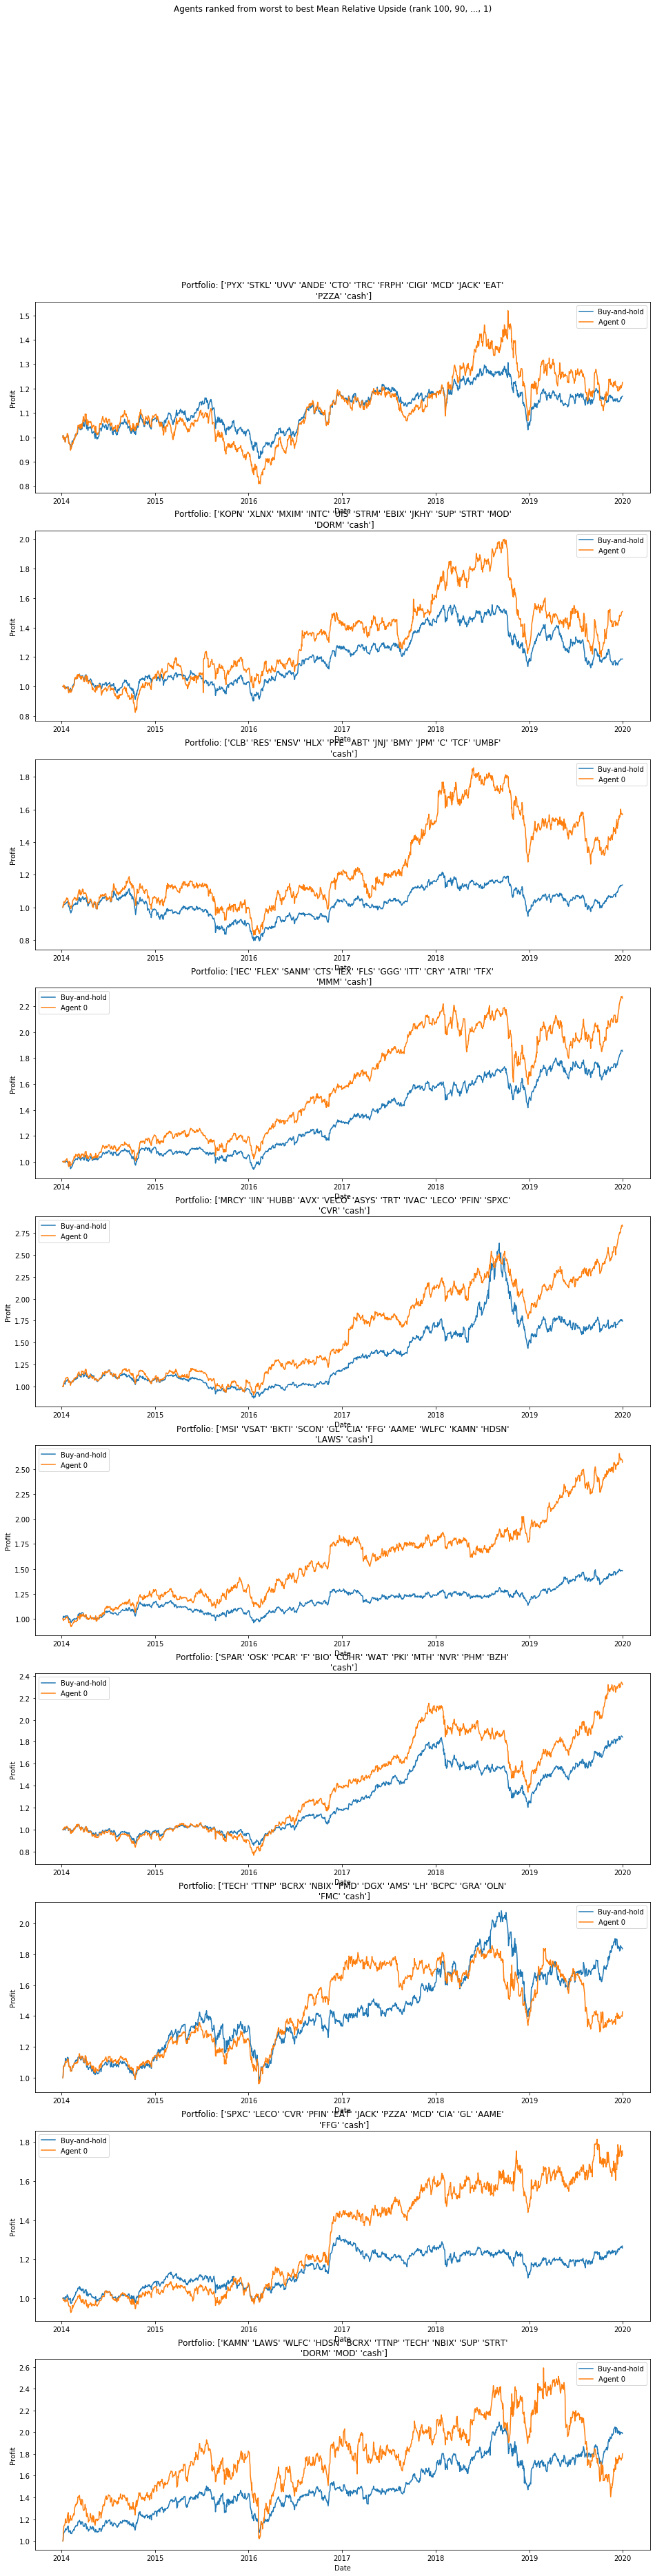

In [19]:
considered = range(len(all_data))
considered = range(10)
plt.figure(figsize=(16, 7*len(considered)*n_logs))
fig, axs = plt.subplots(max(len(considered)*n_logs,2),figsize=(16,6*max(len(considered)*n_logs,2)))
fig.suptitle("Agents ranked from worst to best Mean Relative Upside (rank 100, 90, ..., 1)")
for i in range(len(considered)):
    l = considered[i]
    for j in range(n_logs):
        d = all_data[l][j]
        sns.lineplot(x=d.Date,y=d['Base Profit'],ax=axs[i*n_logs+j])
        sns.lineplot(x=d.Date,y=d['Profit'],ax=axs[i*n_logs+j])
        axs[i*n_logs+j].legend(['Buy-and-hold',]+["Agent {}".format(str(k)) for k in range(n_logs)])
        axs[i*n_logs+j].set_title("Portfolio: {}".format(str(d.columns[5:].values)))
fig.savefig("profit.png")

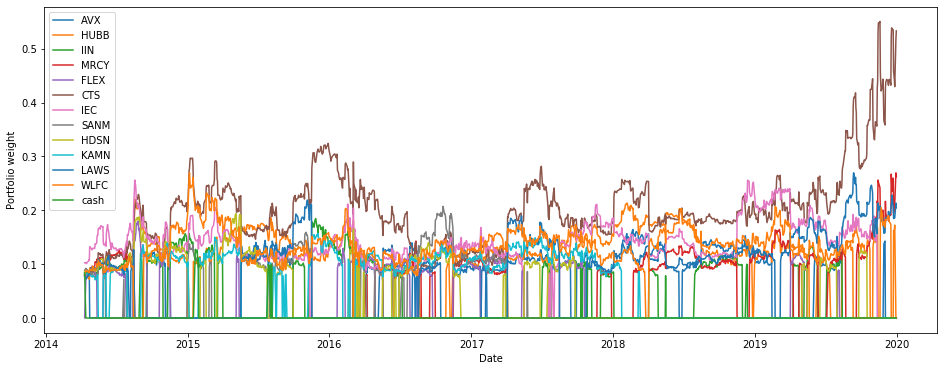

In [52]:
#tickers = ['PEP','KO','KDP','MNST','cash']
data = all_data[0][0]
include_cash = True
tickers = data.columns[5:]
if not include_cash: tickers = tickers[:-int('cash' in tickers)]
plt.figure(figsize=(16, 6))
for ticker in tickers:
    sns.lineplot(x=data.Date,y=data[ticker])
plt.legend(tickers)
plt.ylabel("Portfolio weight")
plt.savefig("weights.png")

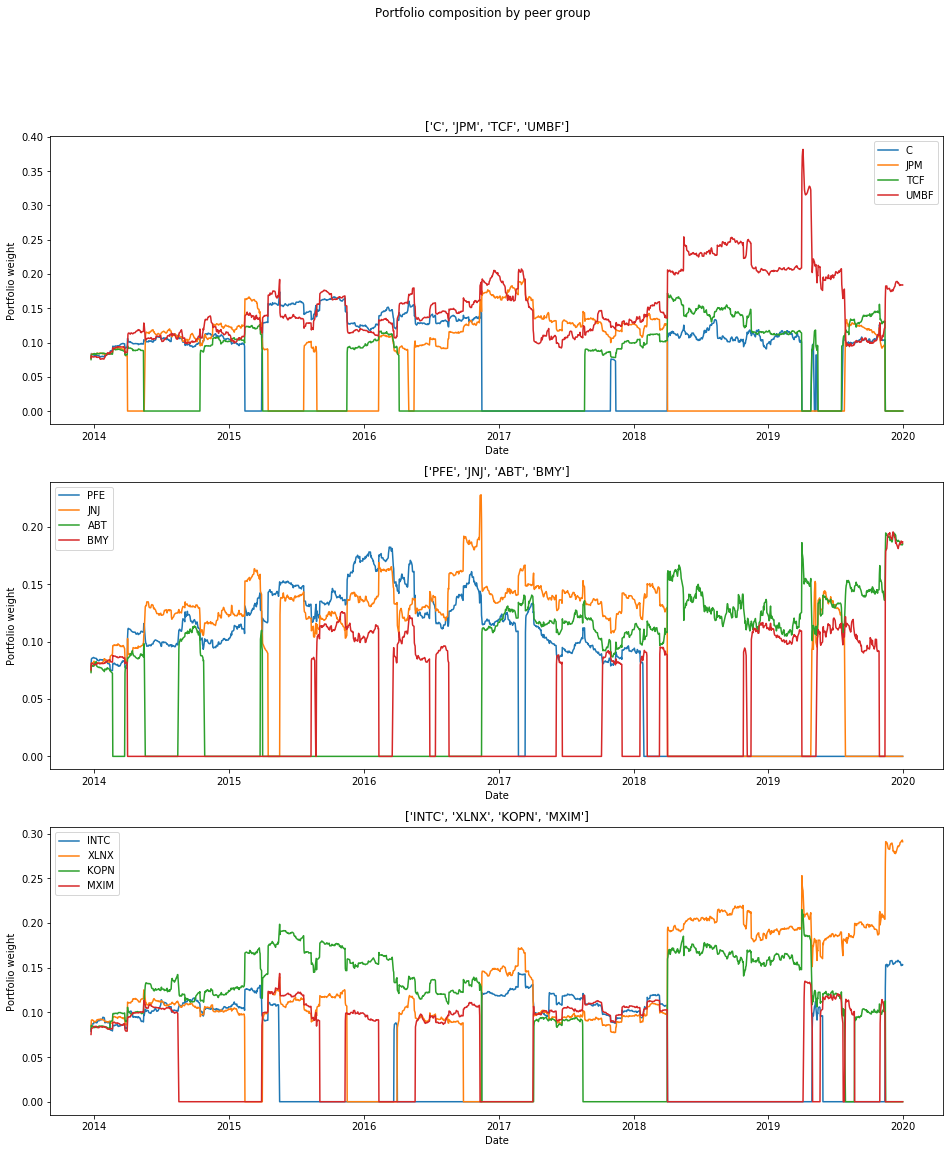

In [20]:
data = all_data[0][0]
tickers = data.columns[5:]
fig, axs = plt.subplots(max(len(tickers)//group_size,2),figsize=(16,6*max(len(tickers)//group_size,2)))
fig.suptitle("Portfolio composition by peer group")
for i in range(len(tickers)//group_size):
    ts = tickers[i*group_size:(i+1)*group_size]
    for ticker in ts:
        sns.lineplot(x=data.Date,y=data[ticker],ax=axs[i])
        
    axs[i].set_title(str(list(ts)))
    axs[i].legend(ts)
    axs[i].set_ylabel("Portfolio weight")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (27,28,36,37,38,39,43,45,46,47,52,54,55,56,57,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (27,28,37,47,55,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/co

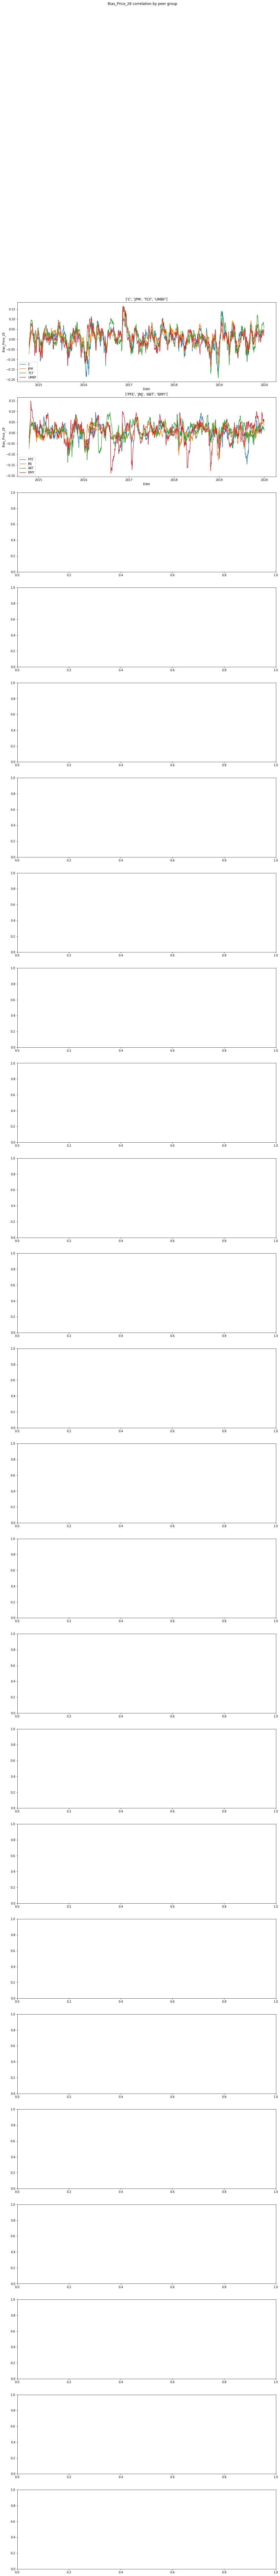

In [12]:
field = 'Bias_Price_28'
fig, axs = plt.subplots(max(len(tickers)//group_size,2),figsize=(16,6*max(len(tickers)//group_size,2)))
fig.suptitle("{} correlation by peer group".format(field))
axs = axs.flatten()
for i in range(len(tickers)//group_size):
    ts = tickers[i*group_size:(i+1)*group_size]
    results = pd.DataFrame()
    for t in ts:
        path = os.path.relpath("/Users/anthonyrathe/repos/BRIKSScreener/data/cleaned/v2/{}_1_1.csv".format(t))
        d = pd.read_csv(path,index_col=0,parse_dates=True)
        results[t] = d.loc[data.Date,field]
        sns.lineplot(x=data.Date,y=results[t],ax=axs[i])
    axs[i].set_title(str(list(ts)))
    axs[i].legend(ts)
    axs[i].set_ylabel(field)

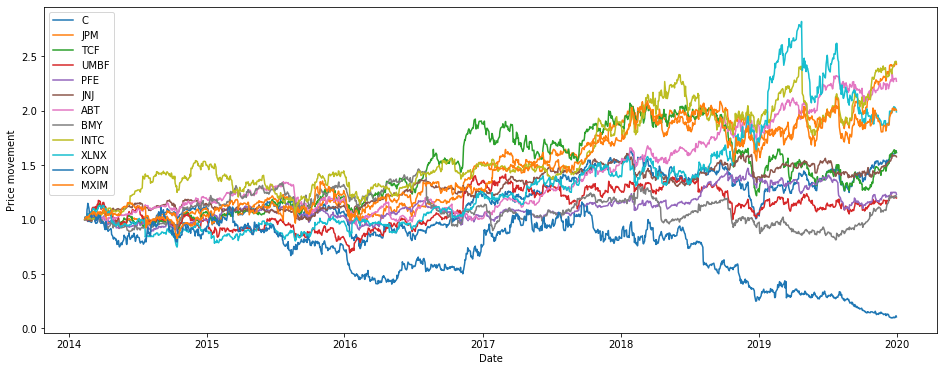

In [278]:
plt.figure(figsize=(16, 6))

prices = pd.DataFrame()
for ticker in tickers[:-1]:
    path = os.path.relpath("../../../../BRIKSScreener/data/raw/prices/{}.csv".format(ticker))
    price = pd.read_csv(path,index_col=0,parse_dates=True)['open']
    price = price.loc[data.Date]
    prices[ticker] = price
    price = price.values/price.iloc[0]
    sns.lineplot(x=data.Date,y=price)
plt.legend(tickers)
plt.ylabel("Price movement")
plt.savefig("prices.png")

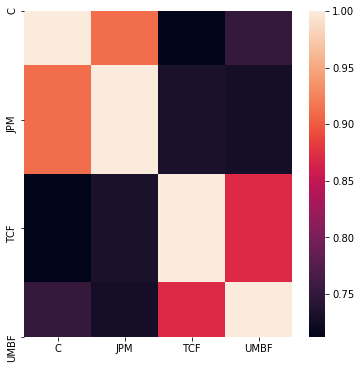

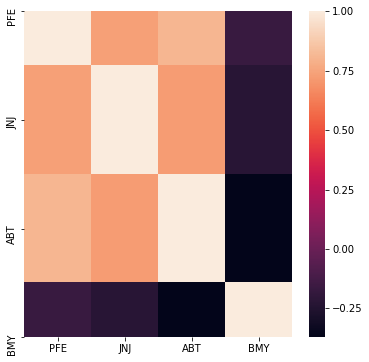

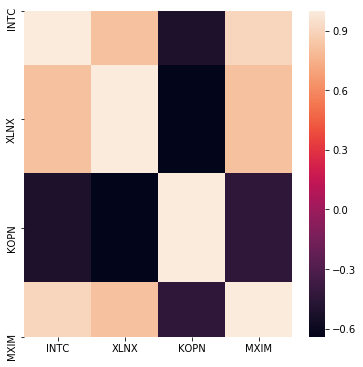

In [291]:
for i in range(len(tickers)//group_size):
    plt.figure(figsize=(6, 6))
    sns.heatmap(prices[tickers[i*group_size:(i+1)*group_size]].corr())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (27,28,36,37,38,39,43,45,46,47,52,54,55,56,57,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (27,28,37,47,55,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/co

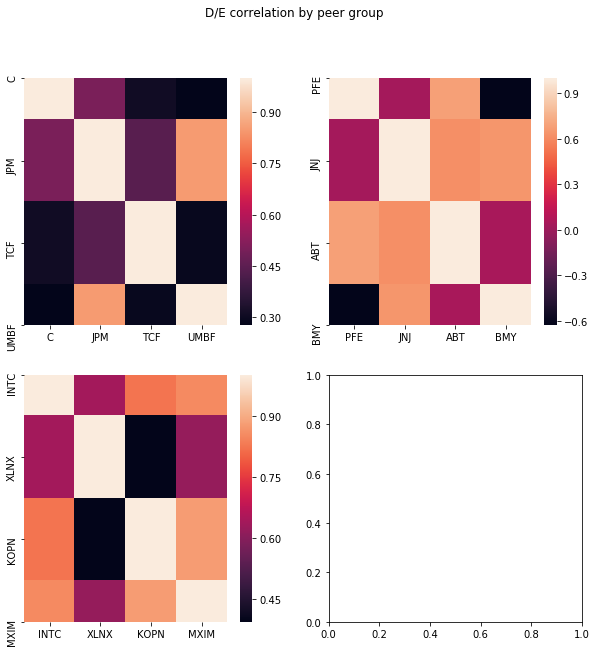

In [315]:
field = 'D/E'
fig, axs = plt.subplots(2,2,figsize=(10,10))
fig.suptitle("{} correlation by peer group".format(field))
axs = axs.flatten()
for i in range(len(tickers)//group_size):
    ts = tickers[i*group_size:(i+1)*group_size]
    results = pd.DataFrame()
    for t in ts:
        path = os.path.relpath("/Users/anthonyrathe/repos/BRIKSScreener/data/cleaned/v2/{}_1_1.csv".format(t))
        d = pd.read_csv(path,index_col=0,parse_dates=True)
        results[t] = d.loc[data.Date,field]

    sns.heatmap(results[ts].corr(),ax=axs[i])

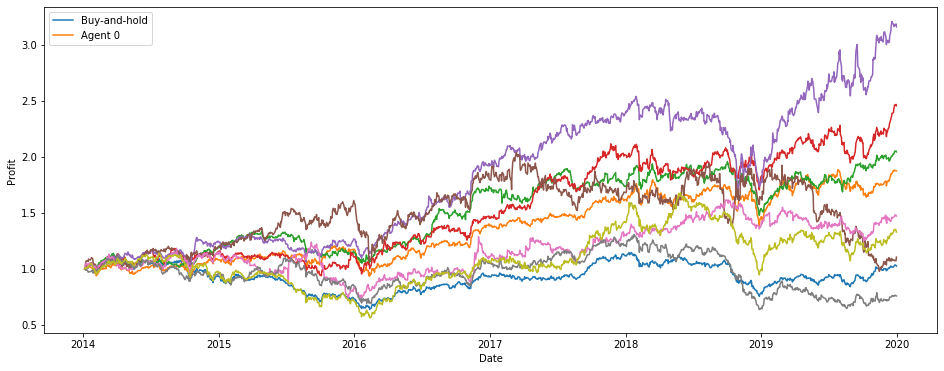

In [58]:
plt.figure(figsize=(16, 6))
data = all_data[7][0]
sns.lineplot(x=data.Date,y=data['Base Profit'])
for ds in all_data:
    for d in ds:
        sns.lineplot(x=d.Date,y=d['Profit'])
plt.legend(['Buy-and-hold',]+["Agent {}".format(str(i)) for i in range(n_logs)])
plt.ylabel("Profit")
plt.savefig("profit.png")

Text(0, 0.5, 'Profit')

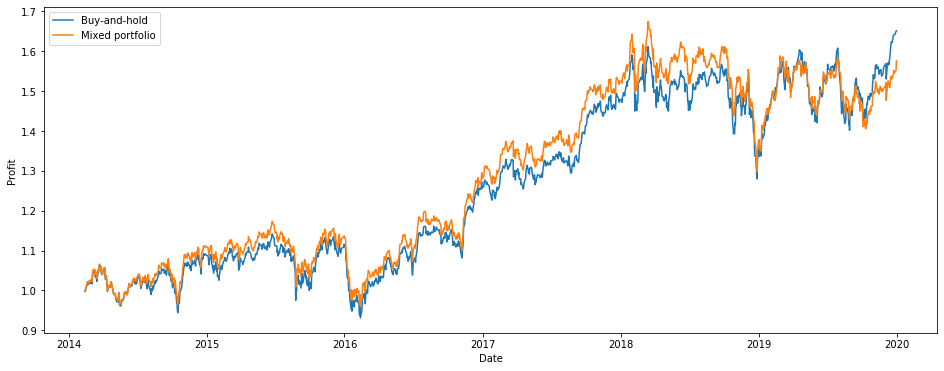

In [245]:
plt.figure(figsize=(16, 6))

sns.lineplot(x=data.Date,y=data['Base Profit'])
total_profit = None
for d in all_data:
    if total_profit is None:
        total_profit = d['Profit']
    else:
        total_profit += d['Profit']

total_profit = np.array(total_profit)/len(all_data)
sns.lineplot(x=d.Date,y=total_profit)
plt.legend(['Buy-and-hold','Mixed portfolio'])
plt.ylabel("Profit")


In [13]:
def sharpe(returns,risk_free=None):
    dates = returns.index
    if risk_free is None:
        risk_free = (1.02**((dates.max()-dates.min()).days/365))**(1/len(dates))
        risk_free = np.array([1,]+[risk_free**i for i in range(1,len(dates))])
    excess_returns = np.array(returns)-risk_free
    mu_excess_returns = excess_returns.mean()
    sigma_excess_returns = excess_returns.std()
    if mu_excess_returns < 0:
        return -sqrt(abs(mu_excess_returns)/sigma_excess_returns)
    else:
        return sqrt(mu_excess_returns/sigma_excess_returns)
def cagr(returns):
    return returns.iloc[-1]**(365.25/((returns.index.max()-returns.index.min()).days))-1
def max_drawdown(returns,years=None):
    if years is not None:
        returns = np.array(returns[returns.index>(returns.index.max()-datetime.timedelta(days=365*years))])
    return np.max((1-returns/np.maximum.accumulate(returns))) # end of the period
def calmar(returns):
    return cagr(returns)/max_drawdown(returns)
def ci_mean(x,confidence=0.95):
    x = np.array(x)
    return stats.norm.interval(confidence, loc=x.mean(), scale=x.std()/sqrt(len(x)))
def ci_mean_diff(x,x_base,confidence=0.95):
    diff = np.array(x)-np.array(x_base)
    return ci_mean(diff,confidence=confidence)
def mean_upside(returns,risk_free=None):
    dates = returns.index
    if risk_free is None:
        risk_free = (1.02**((dates.max()-dates.min()).days/365))**(1/len(dates))
        risk_free = np.array([1,]+[risk_free**i for i in range(1,len(dates))])
    excess_returns = np.array(returns)/risk_free-1
    mu_excess_returns = excess_returns.mean()
    return mu_excess_returns

In [14]:
d = data.set_index('Date')
base_sharpes = []
mean_upsides = []
base_cagrs = []
base_calmars = []
base_mdds = []
sharpes = []
relative_sharpes = []
cagrs = []
calmars = []
mdds = []
for ds in all_data:
    for d in ds:
        d = d.set_index('Date')
        sharpes.append(sharpe(d['Profit']))
        mean_upsides.append(mean_upside(d['Profit'],d['Base Profit']))
        relative_sharpes.append(sharpe(d['Profit'],d['Base Profit']))
        calmars.append(calmar(d['Profit']))
        cagrs.append(cagr(d['Profit']))
        mdds.append(max_drawdown(d['Profit']))
        base_sharpes.append(sharpe(d['Base Profit']))
        base_calmars.append(calmar(d['Base Profit']))
        base_cagrs.append(cagr(d['Base Profit']))
        base_mdds.append(max_drawdown(d['Base Profit']))

draw_zone = 1.0
print("Win-ratio: {}%".format(round((np.array(relative_sharpes)>=draw_zone).sum()/len(relative_sharpes)*100,2)))
print("Draw-ratio: {}%".format(round(((np.array(relative_sharpes)>0) & (np.array(relative_sharpes)<draw_zone)).sum()/len(relative_sharpes)*100,2)))
print("Loss-ratio: {}%".format(round((np.array(relative_sharpes)<=0).sum()/len(relative_sharpes)*100,2)))
print("Relative Sharpes: {}".format(relative_sharpes))
print("Relative Sharpe CI: {}".format(ci_mean(relative_sharpes)))
print("Sharpe CI: {}".format(ci_mean(sharpes)))
print("Calmar CI: {}".format(ci_mean(calmars)))
print("CAGR CI: {}".format(ci_mean(cagrs)))
print("MDD CI: {}".format(ci_mean(mdds)))
print("Sharpe difference CI: {}".format(ci_mean_diff(sharpes,base_sharpes)))
print("Calmar difference CI: {}".format(ci_mean_diff(calmars,base_calmars)))
print("CAGR difference CI: {}".format(ci_mean_diff(cagrs,base_cagrs)))
print("MDD difference CI: {}".format(ci_mean_diff(mdds,base_mdds)))
print("Mean upside CI: {}".format(ci_mean(mean_upsides)))


Win-ratio: 49.0%
Draw-ratio: 33.0%
Loss-ratio: 18.0%
Relative Sharpes: [0.41369871180172435, 1.0438156278296313, 1.1325216488255985, 1.2573447164750653, 1.0991496359083768, 1.1692679546314757, 0.9766365252904627, 0.22273245886577073, 0.9352254819760291, 1.1973952469169171, -1.1289428673403625, 1.057330600148586, 1.2373288736421104, 1.2064884850792146, 1.063929740189209, -0.21990232476920132, 0.8686041460724867, 0.9660956653814965, 0.8148939679422047, 0.9764593392445532, 0.9344609304716193, 0.24112743773987727, 1.1224159541605712, 1.1023179960036529, 0.9530861563441863, 1.0445775338632413, 0.5233134396789455, 1.168949846305812, 1.245937565023736, 1.124946710965113, 0.8351779422814973, 1.2639295844180458, 1.0154157252345468, 1.3172021179629585, 1.4794065561037208, 1.1088124395409624, 1.3461856652271875, 0.9012346288559521, 0.9739935575197969, -1.0423153999441521, -1.3310891513764544, 0.6784018582087891, 1.2542878406652689, 1.2653086669101892, 1.0818045386657593, -0.6143580466567325, 1.15

In [15]:
l = mean_upsides
sorted_l = sorted(l)
bottom = [l.index(s) for s in sorted_l[:5]]
top = [l.index(s) for s in sorted_l[-5:]]
tenths = [l.index(s) for s in sorted_l[0::10]]+[l.index(sorted_l[-1])]
print(bottom)
print(top)
print(tenths)

[10, 40, 91, 53, 50]
[60, 99, 5, 88, 97]
[10, 96, 92, 79, 37, 42, 24, 12, 4, 33, 97]


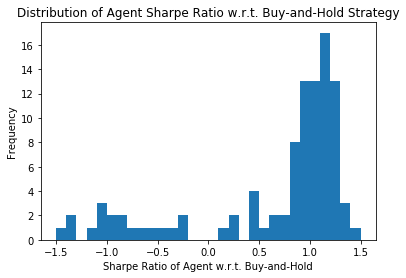

In [10]:
plt.title("Distribution of Agent Sharpe Ratio w.r.t. Buy-and-Hold Strategy")
plt.hist(relative_sharpes,bins=30,range=(-1.5,1.5))
plt.ylabel("Frequency")
plt.xlabel("Sharpe Ratio of Agent w.r.t. Buy-and-Hold")
plt.show()

In [114]:
base_profit = data['Base Profit']
profit_diffs = np.zeros((0,))
for d in all_data:
    profit_diffs = np.concatenate((profit_diffs,(d['Profit']/base_profit)-1))
stats.norm.interval(0.95, loc=profit_diffs.mean(), scale=profit_diffs.std())

(-0.22215856588111071, 0.2832091710958131)

In [88]:
print(data.iloc[-2])

Unnamed: 0                                                  1479
Date                                         2019-12-30 00:00:00
Weights        [0.         0.         0.16666666 0.16666666 0...
Profit                                                   1.70204
Base Profit                                              1.55614
C                                                              0
JPM                                                     0.166667
TCF                                                     0.166667
UMBF                                                           0
PFE                                                            0
JNJ                                                     0.166667
ABT                                                            0
BMY                                                     0.166667
INTC                                                           0
XLNX                                                    0.166667
KOPN                     

Text(0, 0.5, 'Sum of weights')

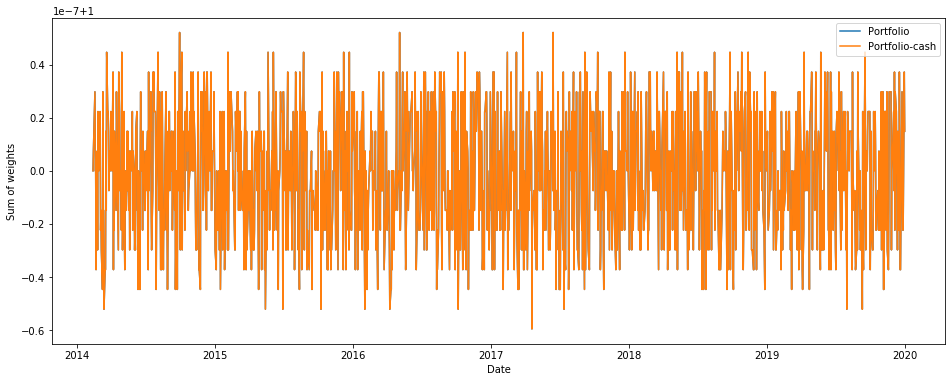

In [79]:
plt.figure(figsize=(16, 6))

sns.lineplot(x=data.Date,y=abs(data.iloc[:,5:]).sum(axis=1))
sns.lineplot(x=data.Date,y=abs(data.iloc[:,5:-1]).sum(axis=1))
plt.legend(["Portfolio","Portfolio-cash"])
plt.ylabel("Sum of weights")

In [ ]:
2019-12-31 00:00:00: 63.85% VS 57.83% base profit
Sharpe: 1.2423456506128405 VS 1.2372318652315342 base
    
2019-12-31 00:00:00: 63.97% VS 57.83% base profit
Sharpe: 1.2421100233501516 VS 1.2372318652315342 base
    
2019-12-31 00:00:00: 63.96% VS 57.83% base profit
Sharpe: 1.2418500893829874 VS 1.2372318652315342 base